<a href="https://colab.research.google.com/github/choikanghoon/Aiffel_study/blob/master/MainQuest/main_Quest02_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 포켓몬 EDA 하기

## 구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 환경 설정

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier
import re
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 불러오기

In [3]:
# 저장된 경로를 작성하여 csv 파일 호출
file_path = '/content/drive/MyDrive/아이펠과정/Main_Quest02/Pokemon.csv'
original_data = pd.read_csv('/content/drive/MyDrive/아이펠과정/Main_Quest02/Pokemon.csv')

In [4]:
# copy() 함수로 만약을 대비하기위해 다른 변수에 명명
pokemon = original_data.copy()

In [5]:
# 정상적으로 나오는지 확인
pokemon.head(2)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False


In [6]:
# Legendary인지 아닌지로 데이터 분리
# legendary가 True인것들만 불러와서 새로 인덱스를 명명해준다.
legendary = pokemon[pokemon['Legendary'] == True].reset_index(drop=True)
# legendary가 False인것들만 불러와서 새로 인덱스를 명명해준다.
originary = pokemon[pokemon['Legendary'] == False].reset_index(drop=True)

In [7]:
# 제대로 나눠졌는지 확인
display(legendary.head(2))
display(originary.head(2))
print(legendary.shape, originary.shape)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False


(65, 13) (735, 13)


True, False로 제대로 나눠진것 확인 되었음

In [8]:
# 결측치가 있는지 확인하기
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Type 2 에 결측치 386개가 있다.

## Columns 정보 확인하기
1. \# : 포켓몬 Id number. 성별이 다르지만 같은 포켓몬인 경우 등은 같은 #값을 가진다. int
2. Name : 포켓몬 이름. 포켓몬 각각의 이름으로 저장되고, 800개의 포켓몬의 이름 데이터는 모두 다르다. (unique) str
3. Type 1 : 첫 번째 속성. 속성을 하나만 가지는 경우 Type 1에 입력된다. str
4. Type 2 : 두 번째 속성. 속성을 하나만 가지는 포켓몬의 경우 Type 2는 NaN(결측값)을 가진다. str
5. Total : 전체 6가지 스탯의 총합. int
6. HP : 포켓몬의 체력. int
7. Attack : 물리 공격력. (scratch, punch 등) int
8. Defense : 물리 공격에 대한 방어력. int
9. Sp. Atk : 특수 공격력. (fire blast, bubble beam 등) int
10. Sp. Def : 특수 공격에 대한 방어력. int
11. Speed : 포켓몬 매치에 대해 어떤 포켓몬이 먼저 공격할지를 결정. (더 높은 포켓몬이 먼저 공격한다) int
12. Generation : 포켓몬의 세대. 현재 데이터에는 6세대까지 있다. int
13. Legendary : 전설의 포켓몬 여부. !! Target feature !! bool

In [9]:
print(len(pokemon.columns))
pokemon.columns

13


Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [10]:
# \# : ID number 확인하기
len(set(pokemon['#']))

721

전체 데이터 800개중 \#의 데이터가 중복을 제외한 데이터가 721개이기 때문에 유니크하지않아 index로 쓸수없고, 같은번호를 가지는 칼럼이 존재한다는 것을 알수 있음

In [11]:
# \#가 중복된 포켓몬이 어떤 방식으로 나눠져있는지 확인하기
pokemon[pokemon['#'] == 6 ]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


포켓몬이 진화할경우 X와 Y가 있는것으로 확인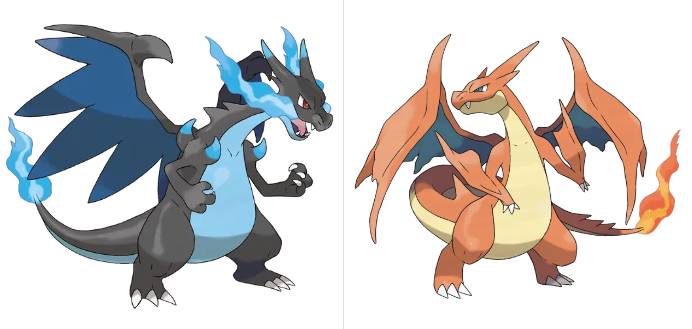

In [12]:
# Name : 이름 칼럼 확인하기
len(set(pokemon["Name"]))

800

겹치는 이름없이 800마리 전원 다 다른 유니크한 데이터 인것을 확인

In [13]:
# Type 1 과 Type 2 칼럼 확인하기
pokemon.loc[[6, 10]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False


In [14]:
# 각 속성의 종류는 총 몇가지인지 확인하기
# set로 중복을 제외한 데이터로 만들고,
# list형태로 만들어 요소화 한후, len으로 요소 개수 확인
len(list(set(pokemon["Type 1"]))), len(list(set(pokemon["Type 2"])))

(18, 19)

In [15]:
# 차집합으로 Type 1과 Type 2에 겹치지않는 요소가 있는지 확인
set(pokemon["Type 2"]) - set(pokemon["Type 1"])

{nan}

NaN 값을 제외한 나머지는 동일한 데이터 요소가 있는것을 확인

In [16]:
# Type을 type 변수에 저장해두기
types = list(set(pokemon["Type 1"]))
print(len(types))
print(types)

18
['Fighting', 'Ice', 'Fire', 'Ground', 'Poison', 'Rock', 'Flying', 'Grass', 'Normal', 'Steel', 'Bug', 'Psychic', 'Dragon', 'Ghost', 'Dark', 'Water', 'Fairy', 'Electric']


In [17]:
# 결측치 확인을했었지만, .isna() 함수로 재차 확인하기
pokemon["Type 2"].isna().sum()

386

### Type 1의 데이터 분포 시각화

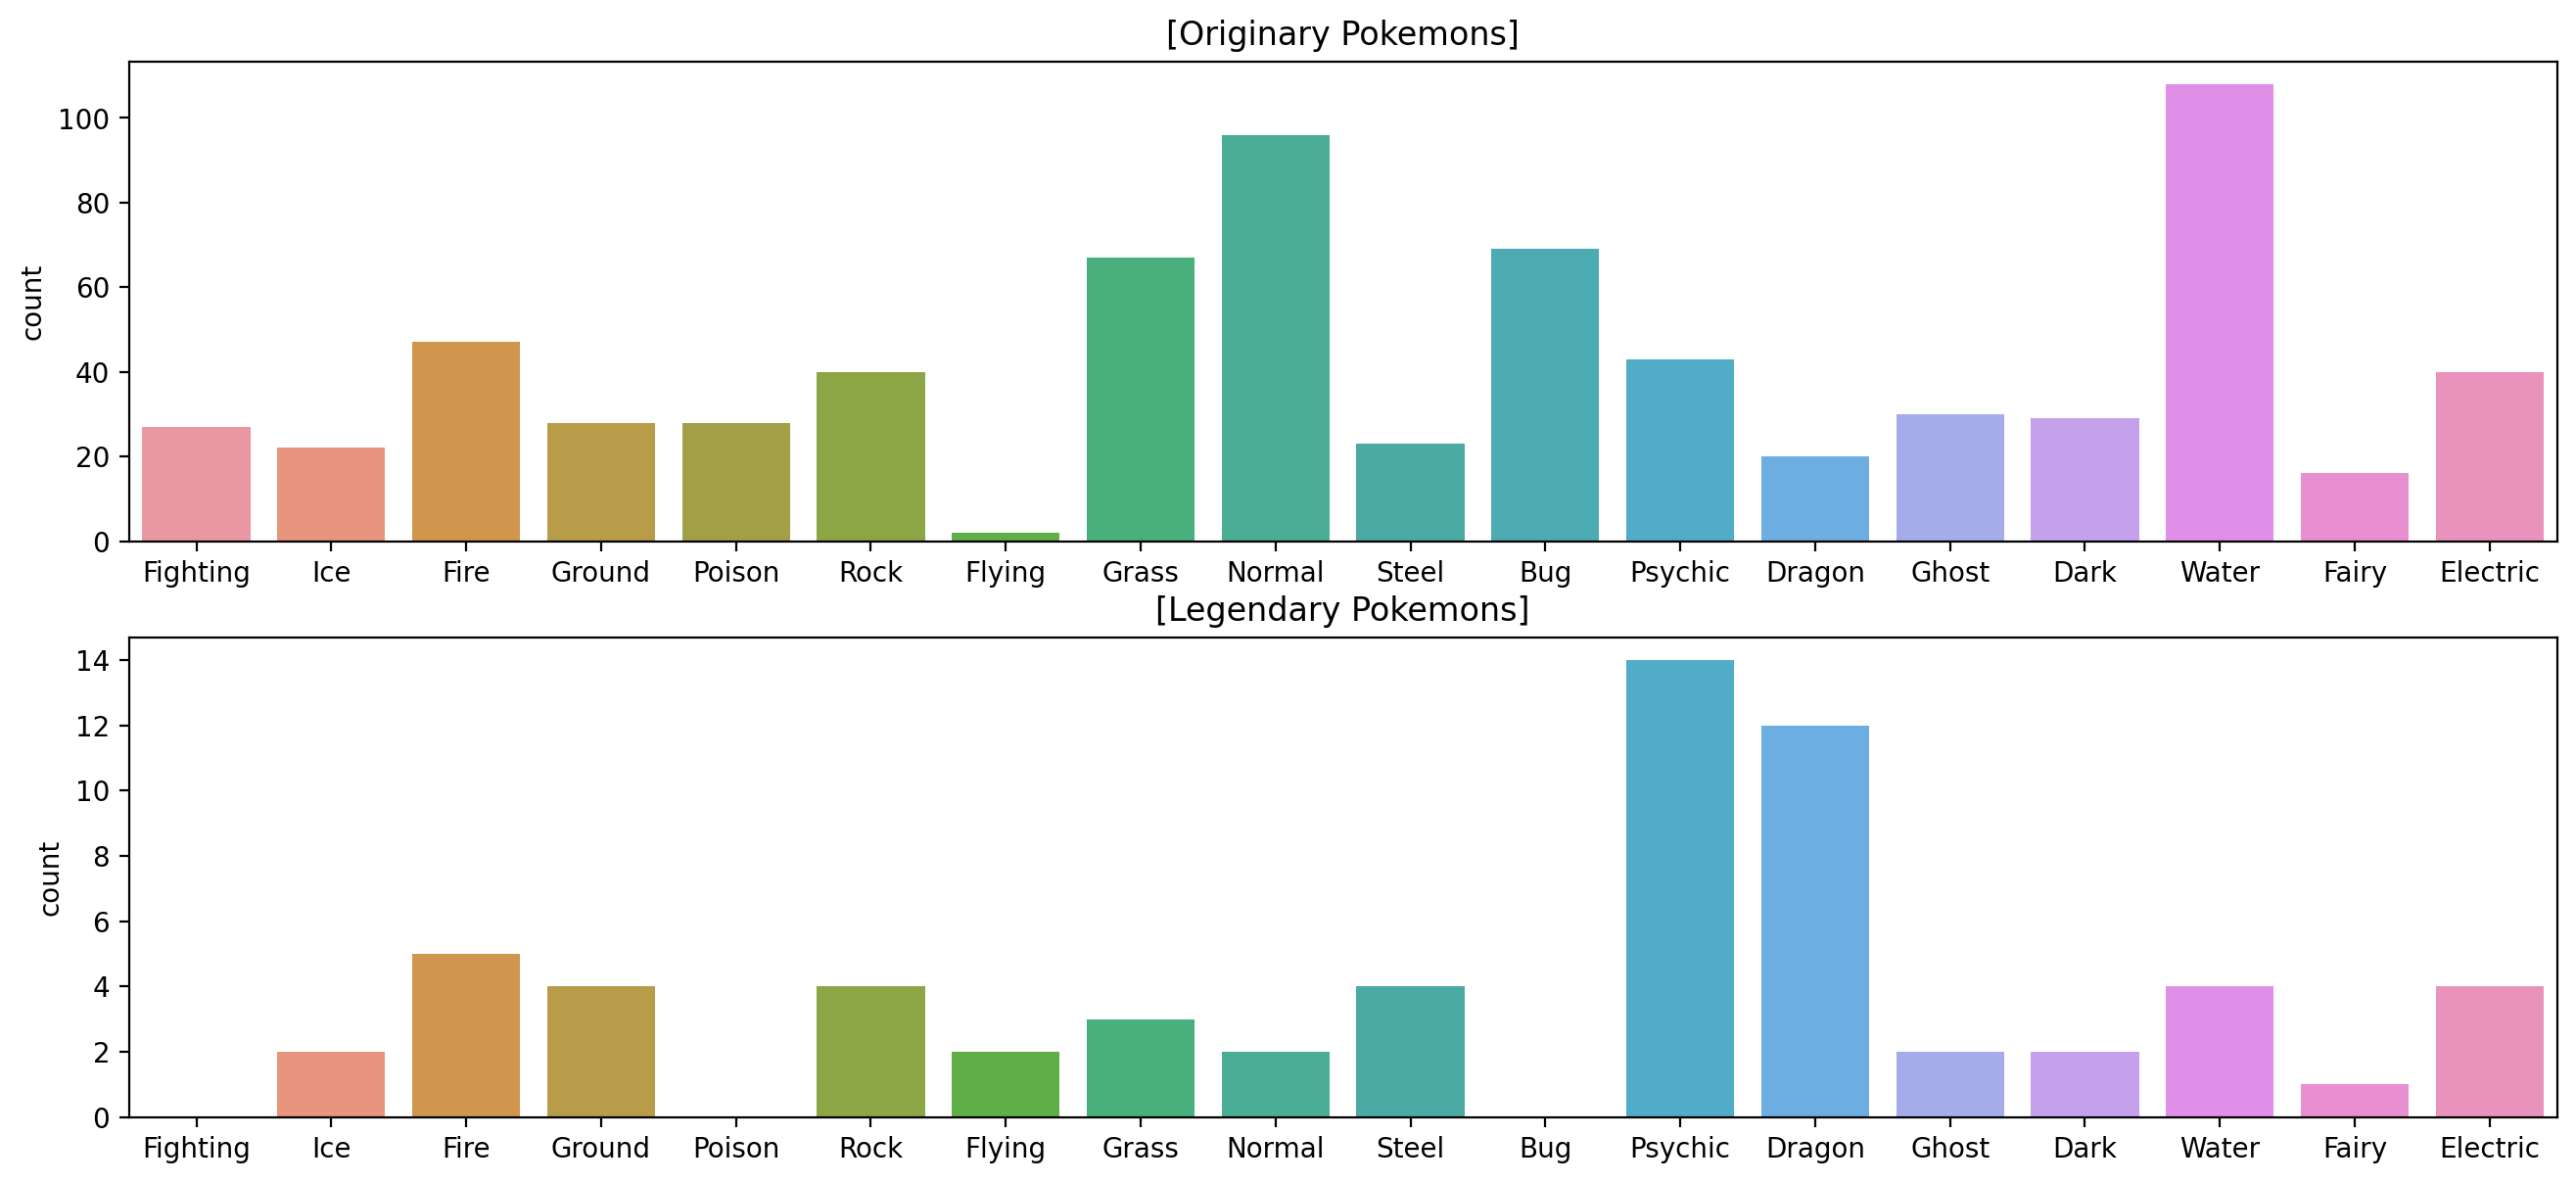

In [18]:
# 그래프 사이즈 조절하기
plt.figure(figsize=(16, 7))
# subplot은 그래프사이즈 안에 여러개로 분리해서 그리게하는 기능
plt.subplot(211)
sns.countplot(data=originary, x="Type 1", order=types).set_xlabel('')
plt.title("[Originary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

In [19]:
type1_pivot = pd.pivot_table(pokemon, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False).transpose()
type1_pivot

Type 1,Flying,Dragon,Psychic,Steel,Ground,Fire,Electric,Rock,Ice,Dark,Ghost,Fairy,Grass,Water,Normal,Poison,Fighting,Bug
Legendary,0.5,0.375,0.245614,0.148148,0.125,0.096154,0.090909,0.090909,0.083333,0.064516,0.0625,0.058824,0.042857,0.035714,0.020408,0.0,0.0,0.0


Flying이 50%로 비율이 제일 높음

### Type 2의 데이터 분포 시각화

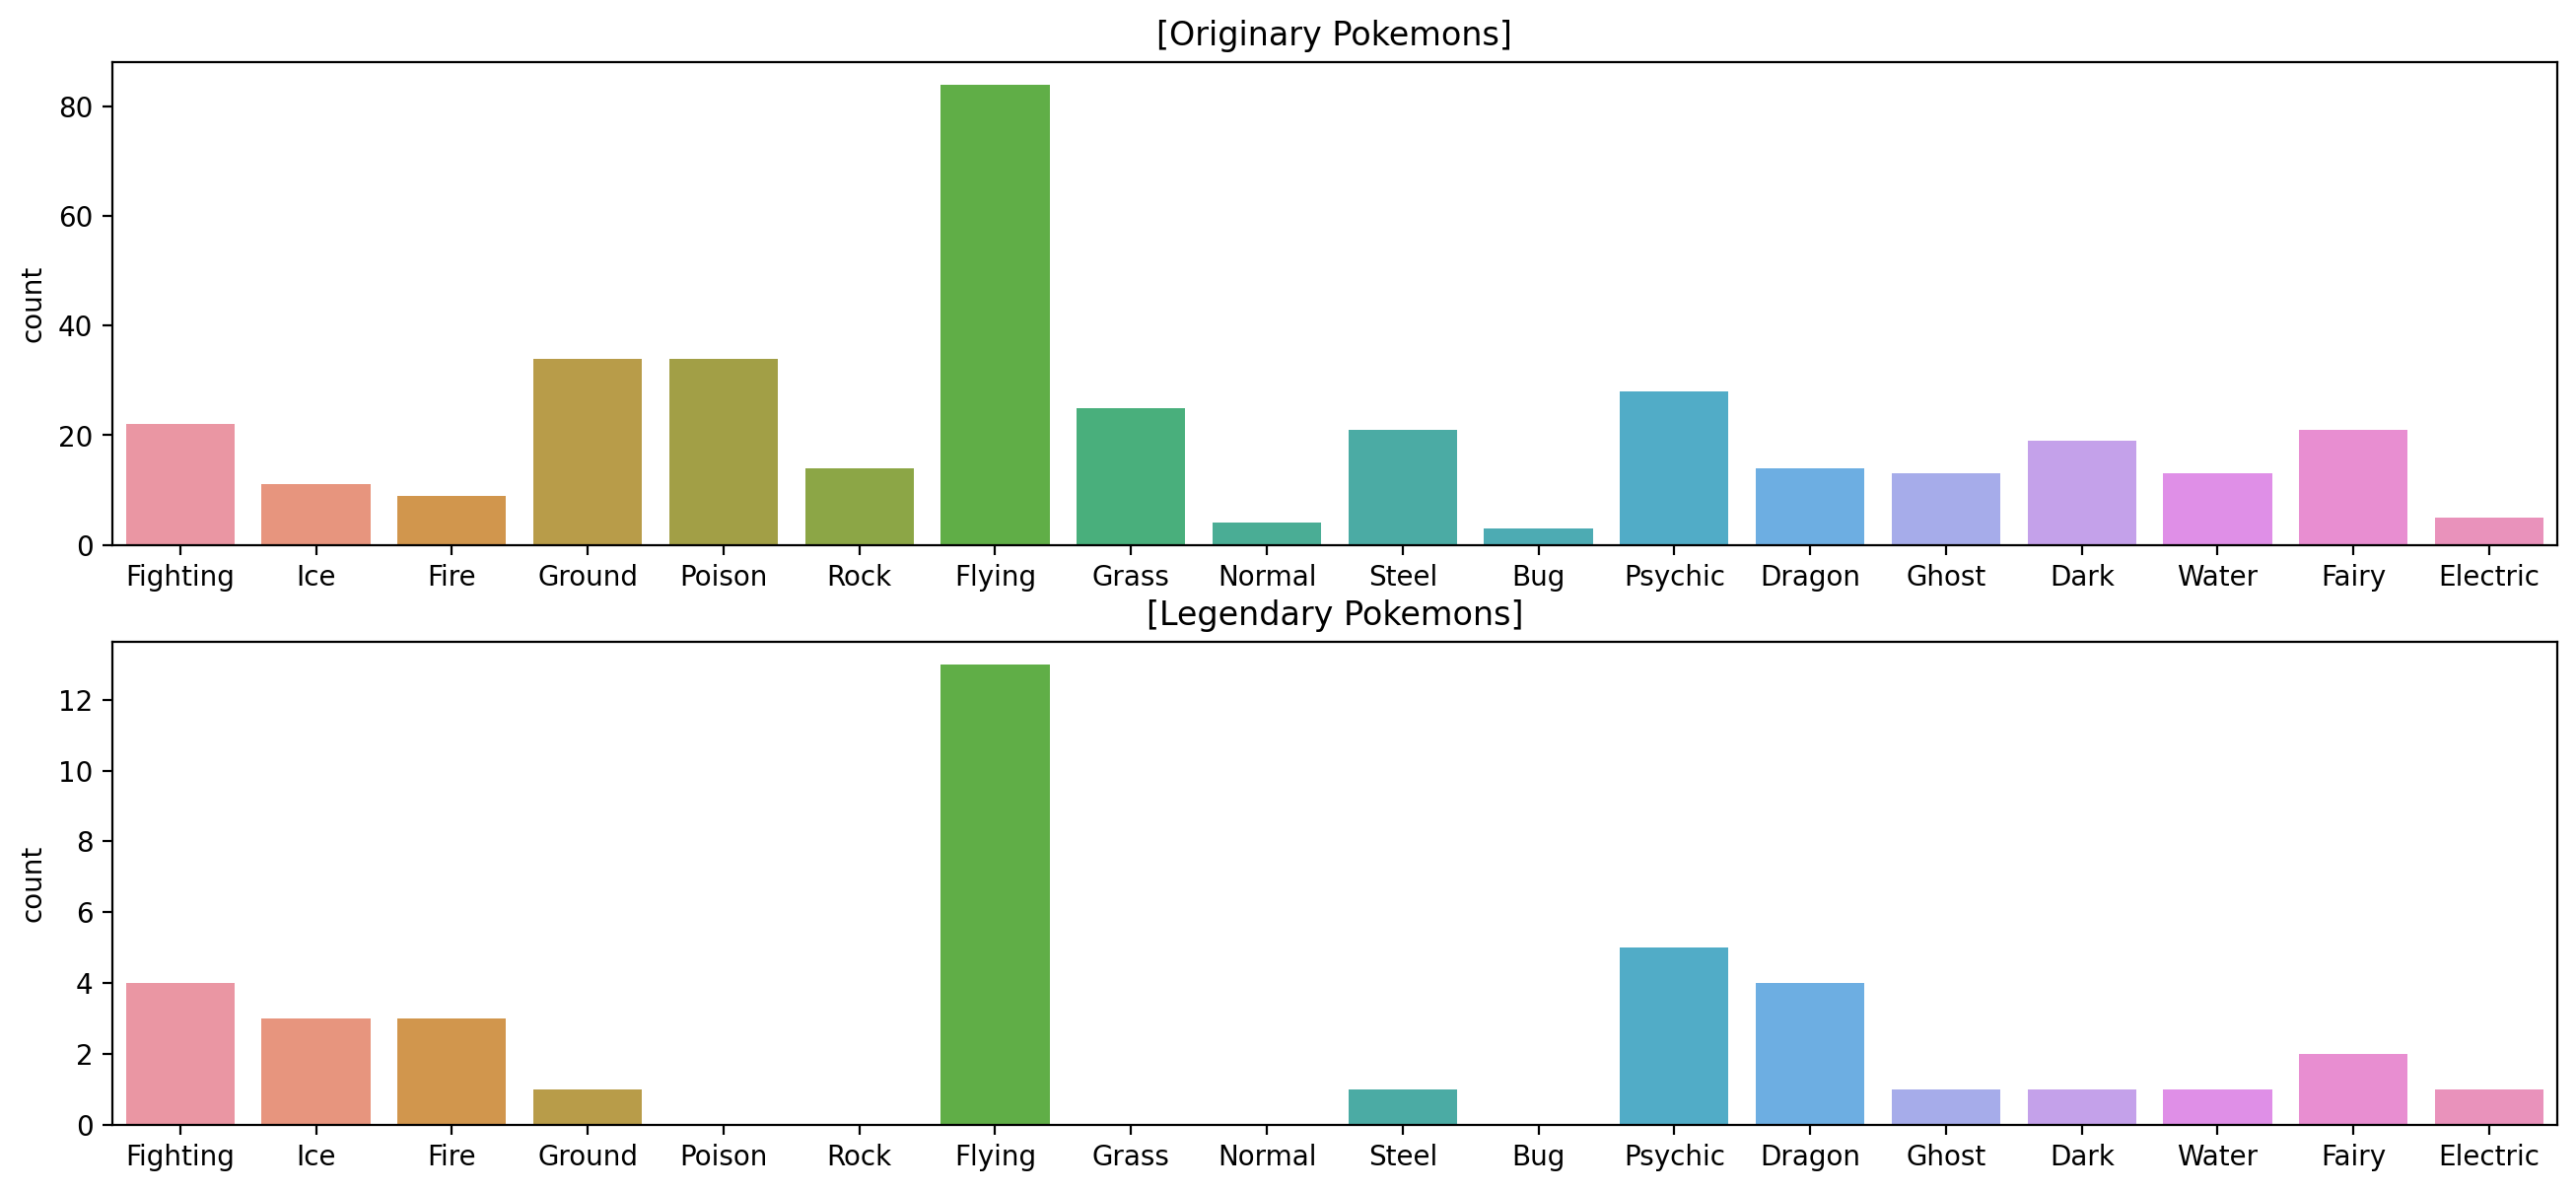

In [20]:
# 그래프 사이즈 조절하기
plt.figure(figsize=(16, 7))
# subplot은 그래프사이즈 안에 여러개로 분리해서 그리게하는 기능
plt.subplot(211)
sns.countplot(data=originary, x="Type 2", order=types).set_xlabel('')
plt.title("[Originary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 2", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

In [21]:
type1_pivot = pd.pivot_table(pokemon, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False).transpose()
type1_pivot

Type 2,Fire,Dragon,Ice,Electric,Fighting,Psychic,Flying,Fairy,Water,Ghost,Dark,Steel,Ground,Rock,Bug,Poison,Normal,Grass
Legendary,0.25,0.222222,0.214286,0.166667,0.153846,0.151515,0.134021,0.086957,0.071429,0.071429,0.05,0.045455,0.028571,0.0,0.0,0.0,0.0,0.0


Fire 가 25%로 비율이 제일 높음

### Total 칼럼과 스탯에 관련한 칼럼들이 일치하지는 확인 및 시각화

In [22]:
# 스텟의 총합을 합치기 위해 리스트 생성
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats

['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

In [23]:
# 0번째 포켓몬의 Total 값과 각 스탯의 값, 각 스탯 다 더한값 확인하기
print("#0 pokemon: ", pokemon.loc[0, "Name"])
print("total: ", int(pokemon.loc[0, "Total"]))
print("stats: ", list(pokemon.loc[0, stats]))
print("sum of all stats: ", sum(list(pokemon.loc[0, stats])))

#0 pokemon:  Bulbasaur
total:  318
stats:  [45, 49, 49, 65, 65, 45]
sum of all stats:  318


stats의 합과 total 의 값이 동일하므로 total이 스탯의 합인 데이터인것을 알수 있음

In [24]:
# total의 값과 stats의 합 값이 동일한지, 그 동일한 개체들의 총합이 몇개인지 확인
total_sum = pokemon['Total'].values # 값만 꺼내오기
stats_sum = pokemon[stats].values.sum(axis=1) # 값만 꺼내오기

equal_count = (total_sum == stats_sum).sum() # 비교했을때 같은것의 갯수 합하기

print(f"Total 값과 stats의 총합이 같은 포켓몬의 개수: {equal_count}")

Total 값과 stats의 총합이 같은 포켓몬의 개수: 800


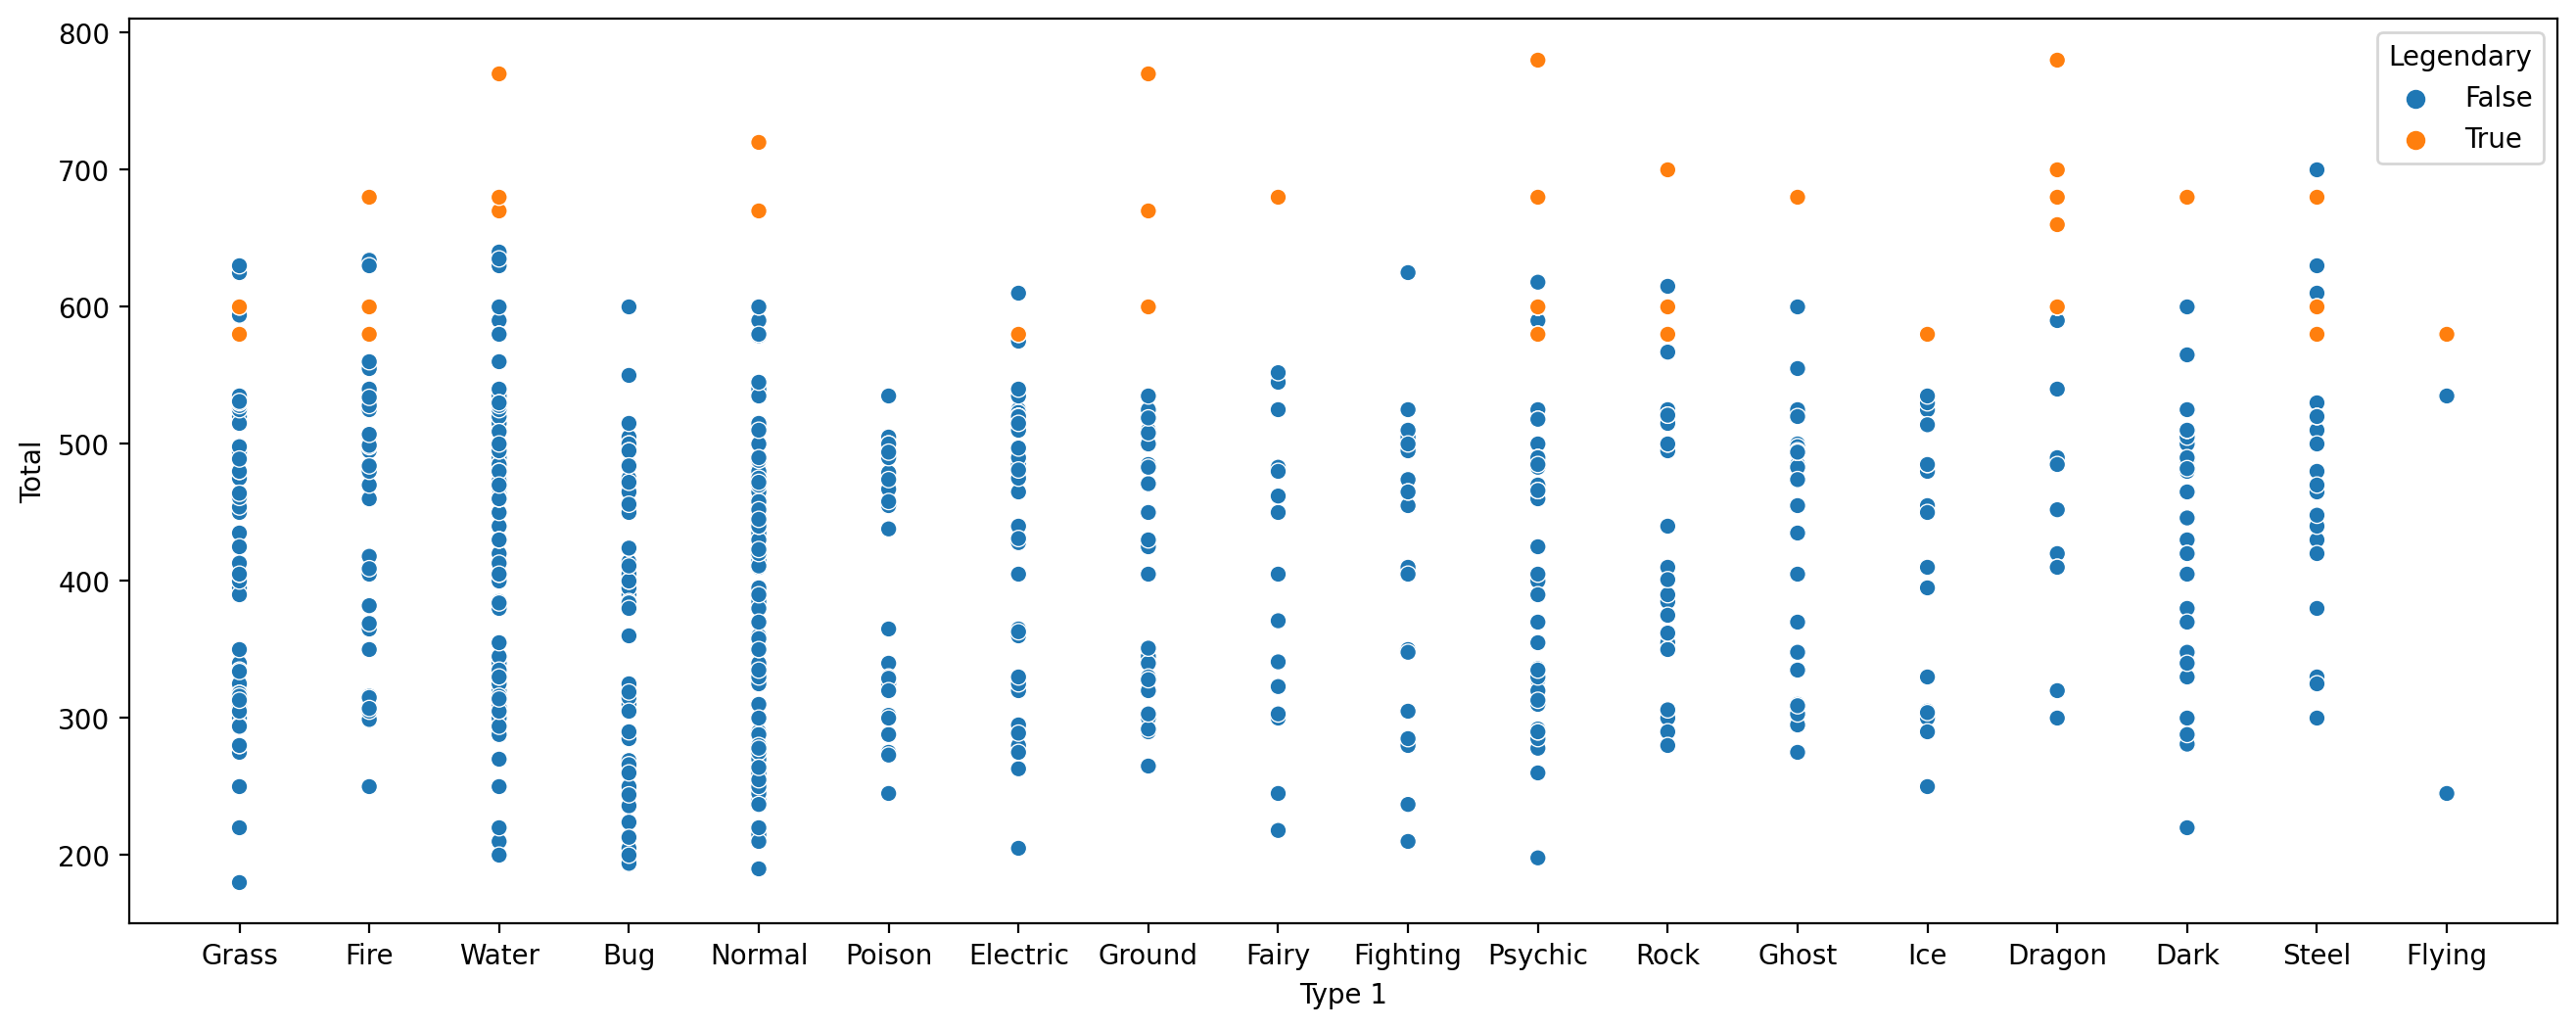

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

sns.scatterplot(data=pokemon, x="Type 1", y="Total", hue="Legendary")
plt.show()

시각화 했을때, 레전드포켓몬의 Total 값이 일반 몬스터보다 평균적으로 높다는 것을 알수 있음

### 세부스탯 : HP, Attack, Defense, Sp. Atk, Sp. Def, Speed 칼럼 분포 시각화

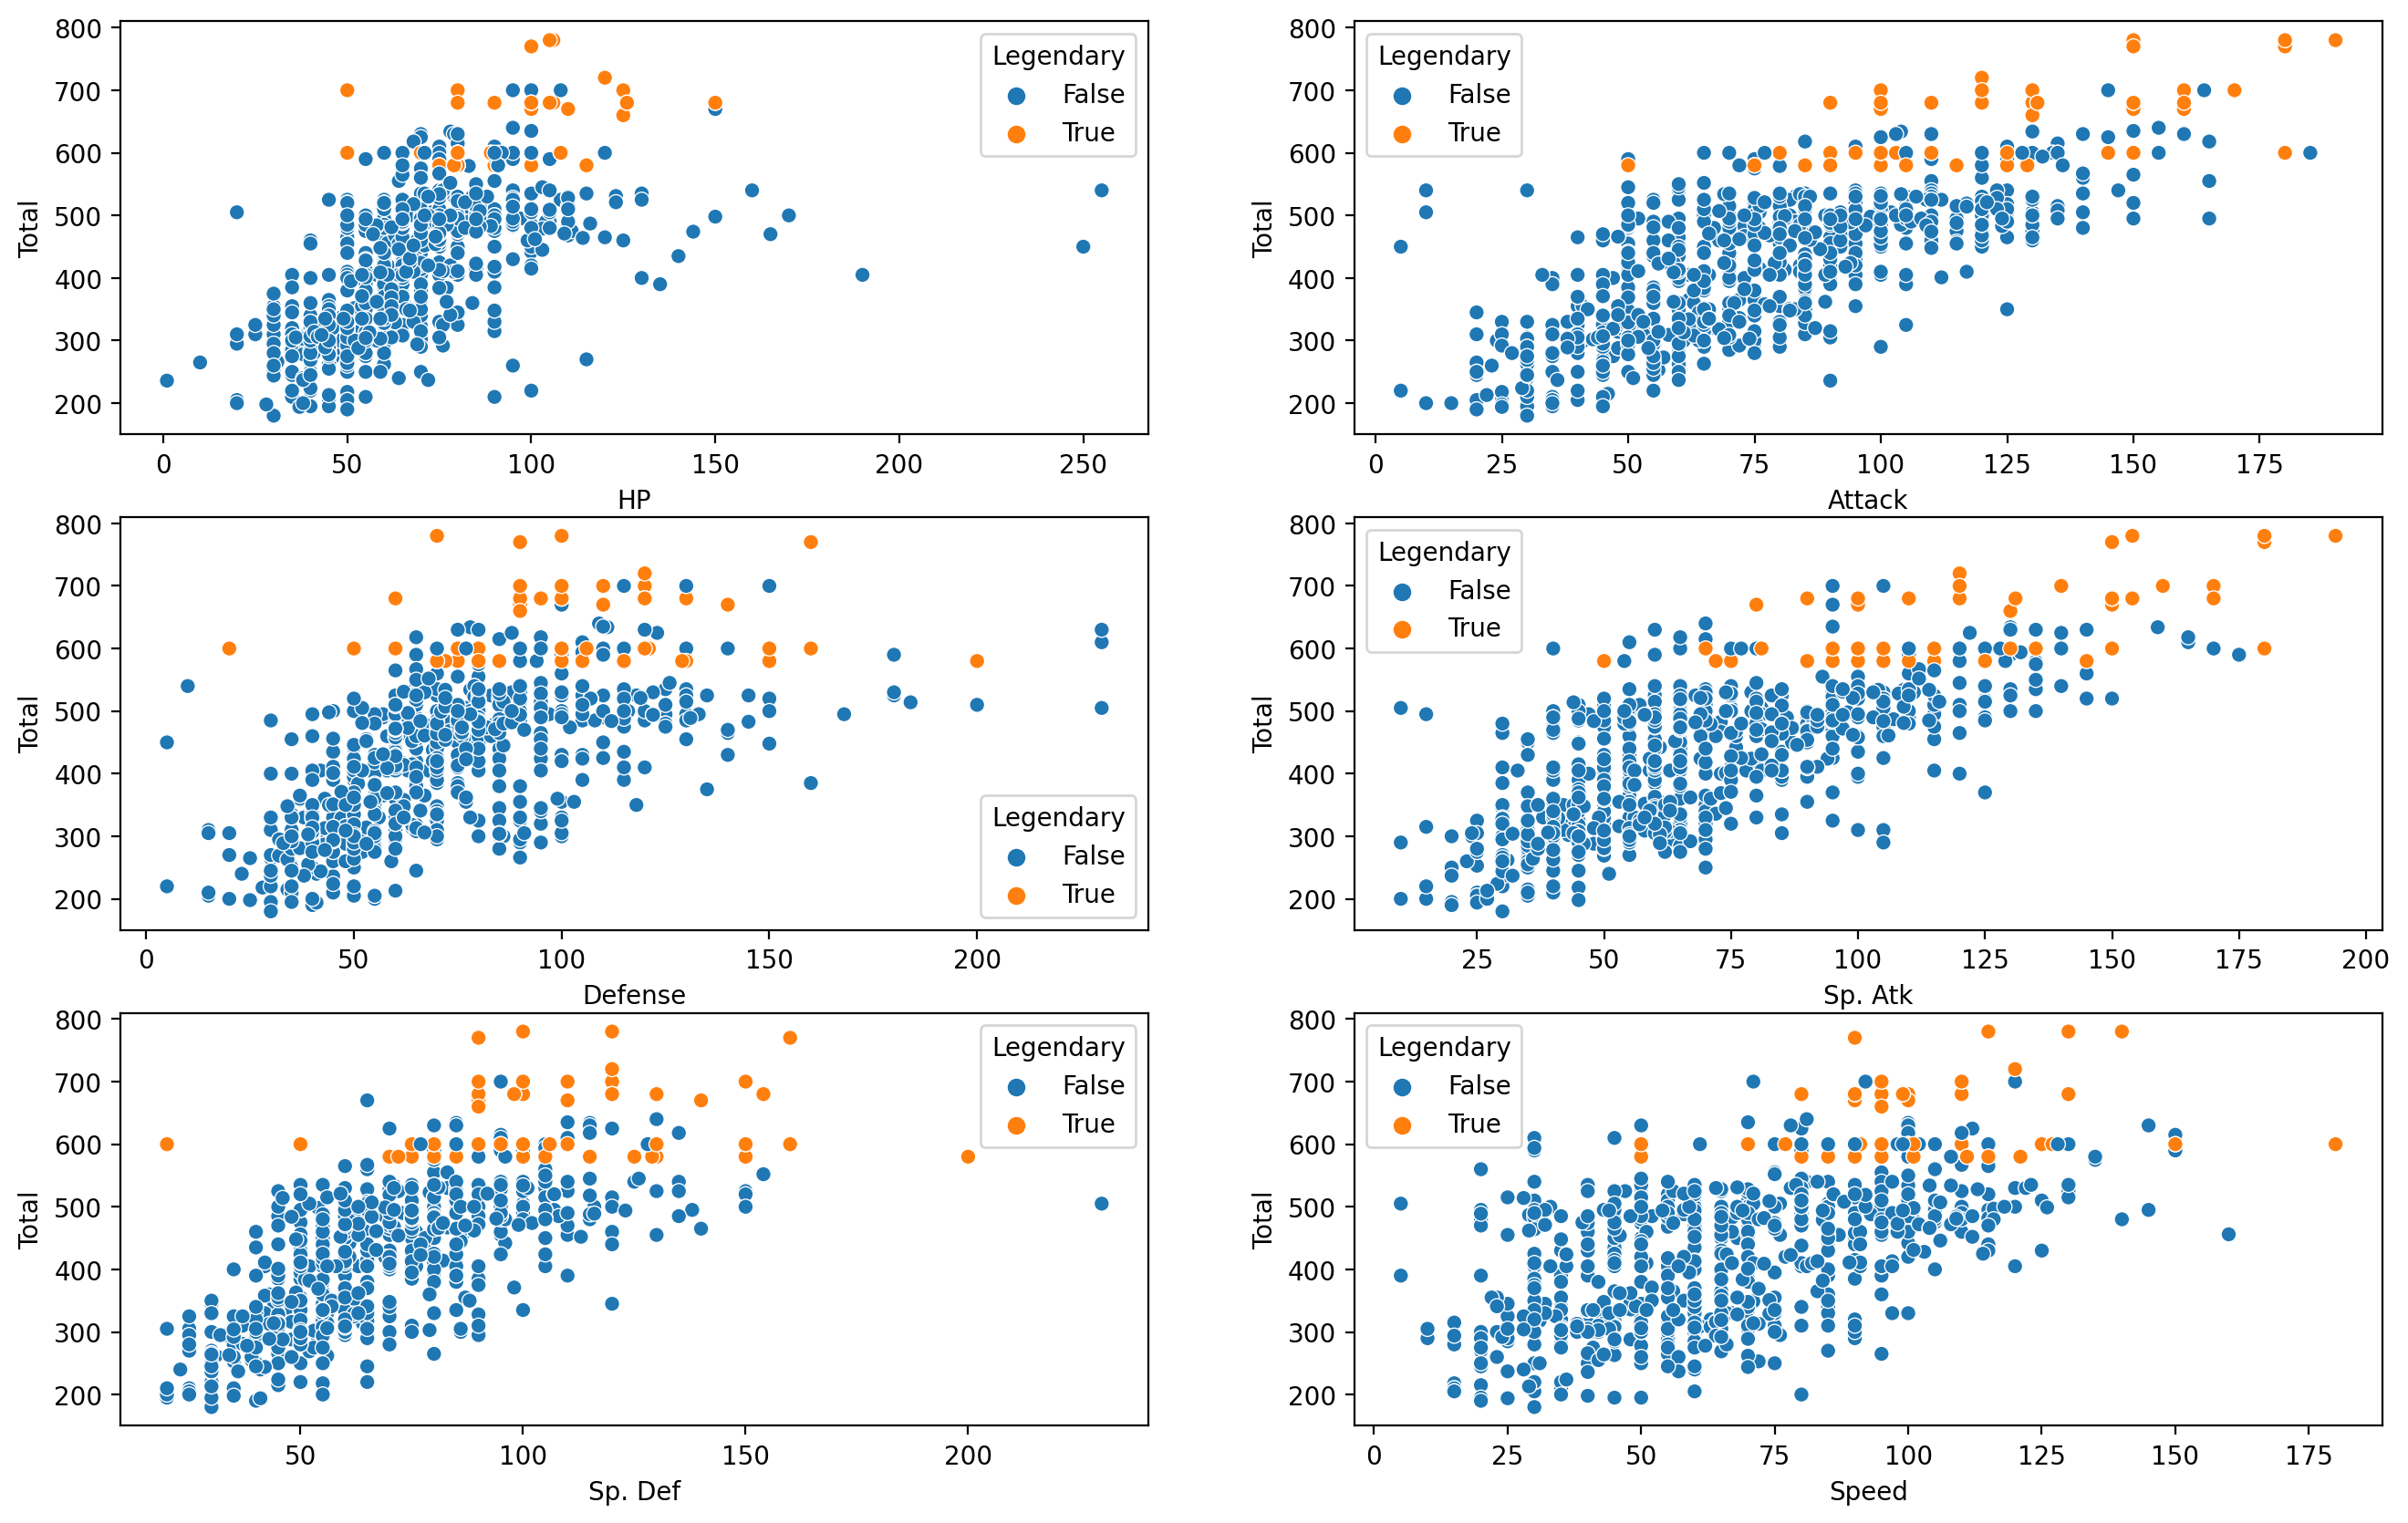

In [26]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(16,10)

# "HP" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="HP", hue="Legendary", ax=ax1)

# "Attack" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Attack", hue="Legendary", ax=ax2)

# "Defense" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Defense", hue="Legendary", ax=ax3)

# "Sp. Atk" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Atk", hue="Legendary", ax=ax4)

# "Sp. Def" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Def", hue="Legendary", ax=ax5)

# "Speed" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Speed", hue="Legendary", ax=ax6)

plt.show()

HP, Defense, Sp. Def 는 레전드포켓몬보다 월등한 캐릭터들이 존재한다.

Attak, Sp. Atk, Speed 는 레전드포켓몬이 많은것들중에 더 비율을 차지한다.

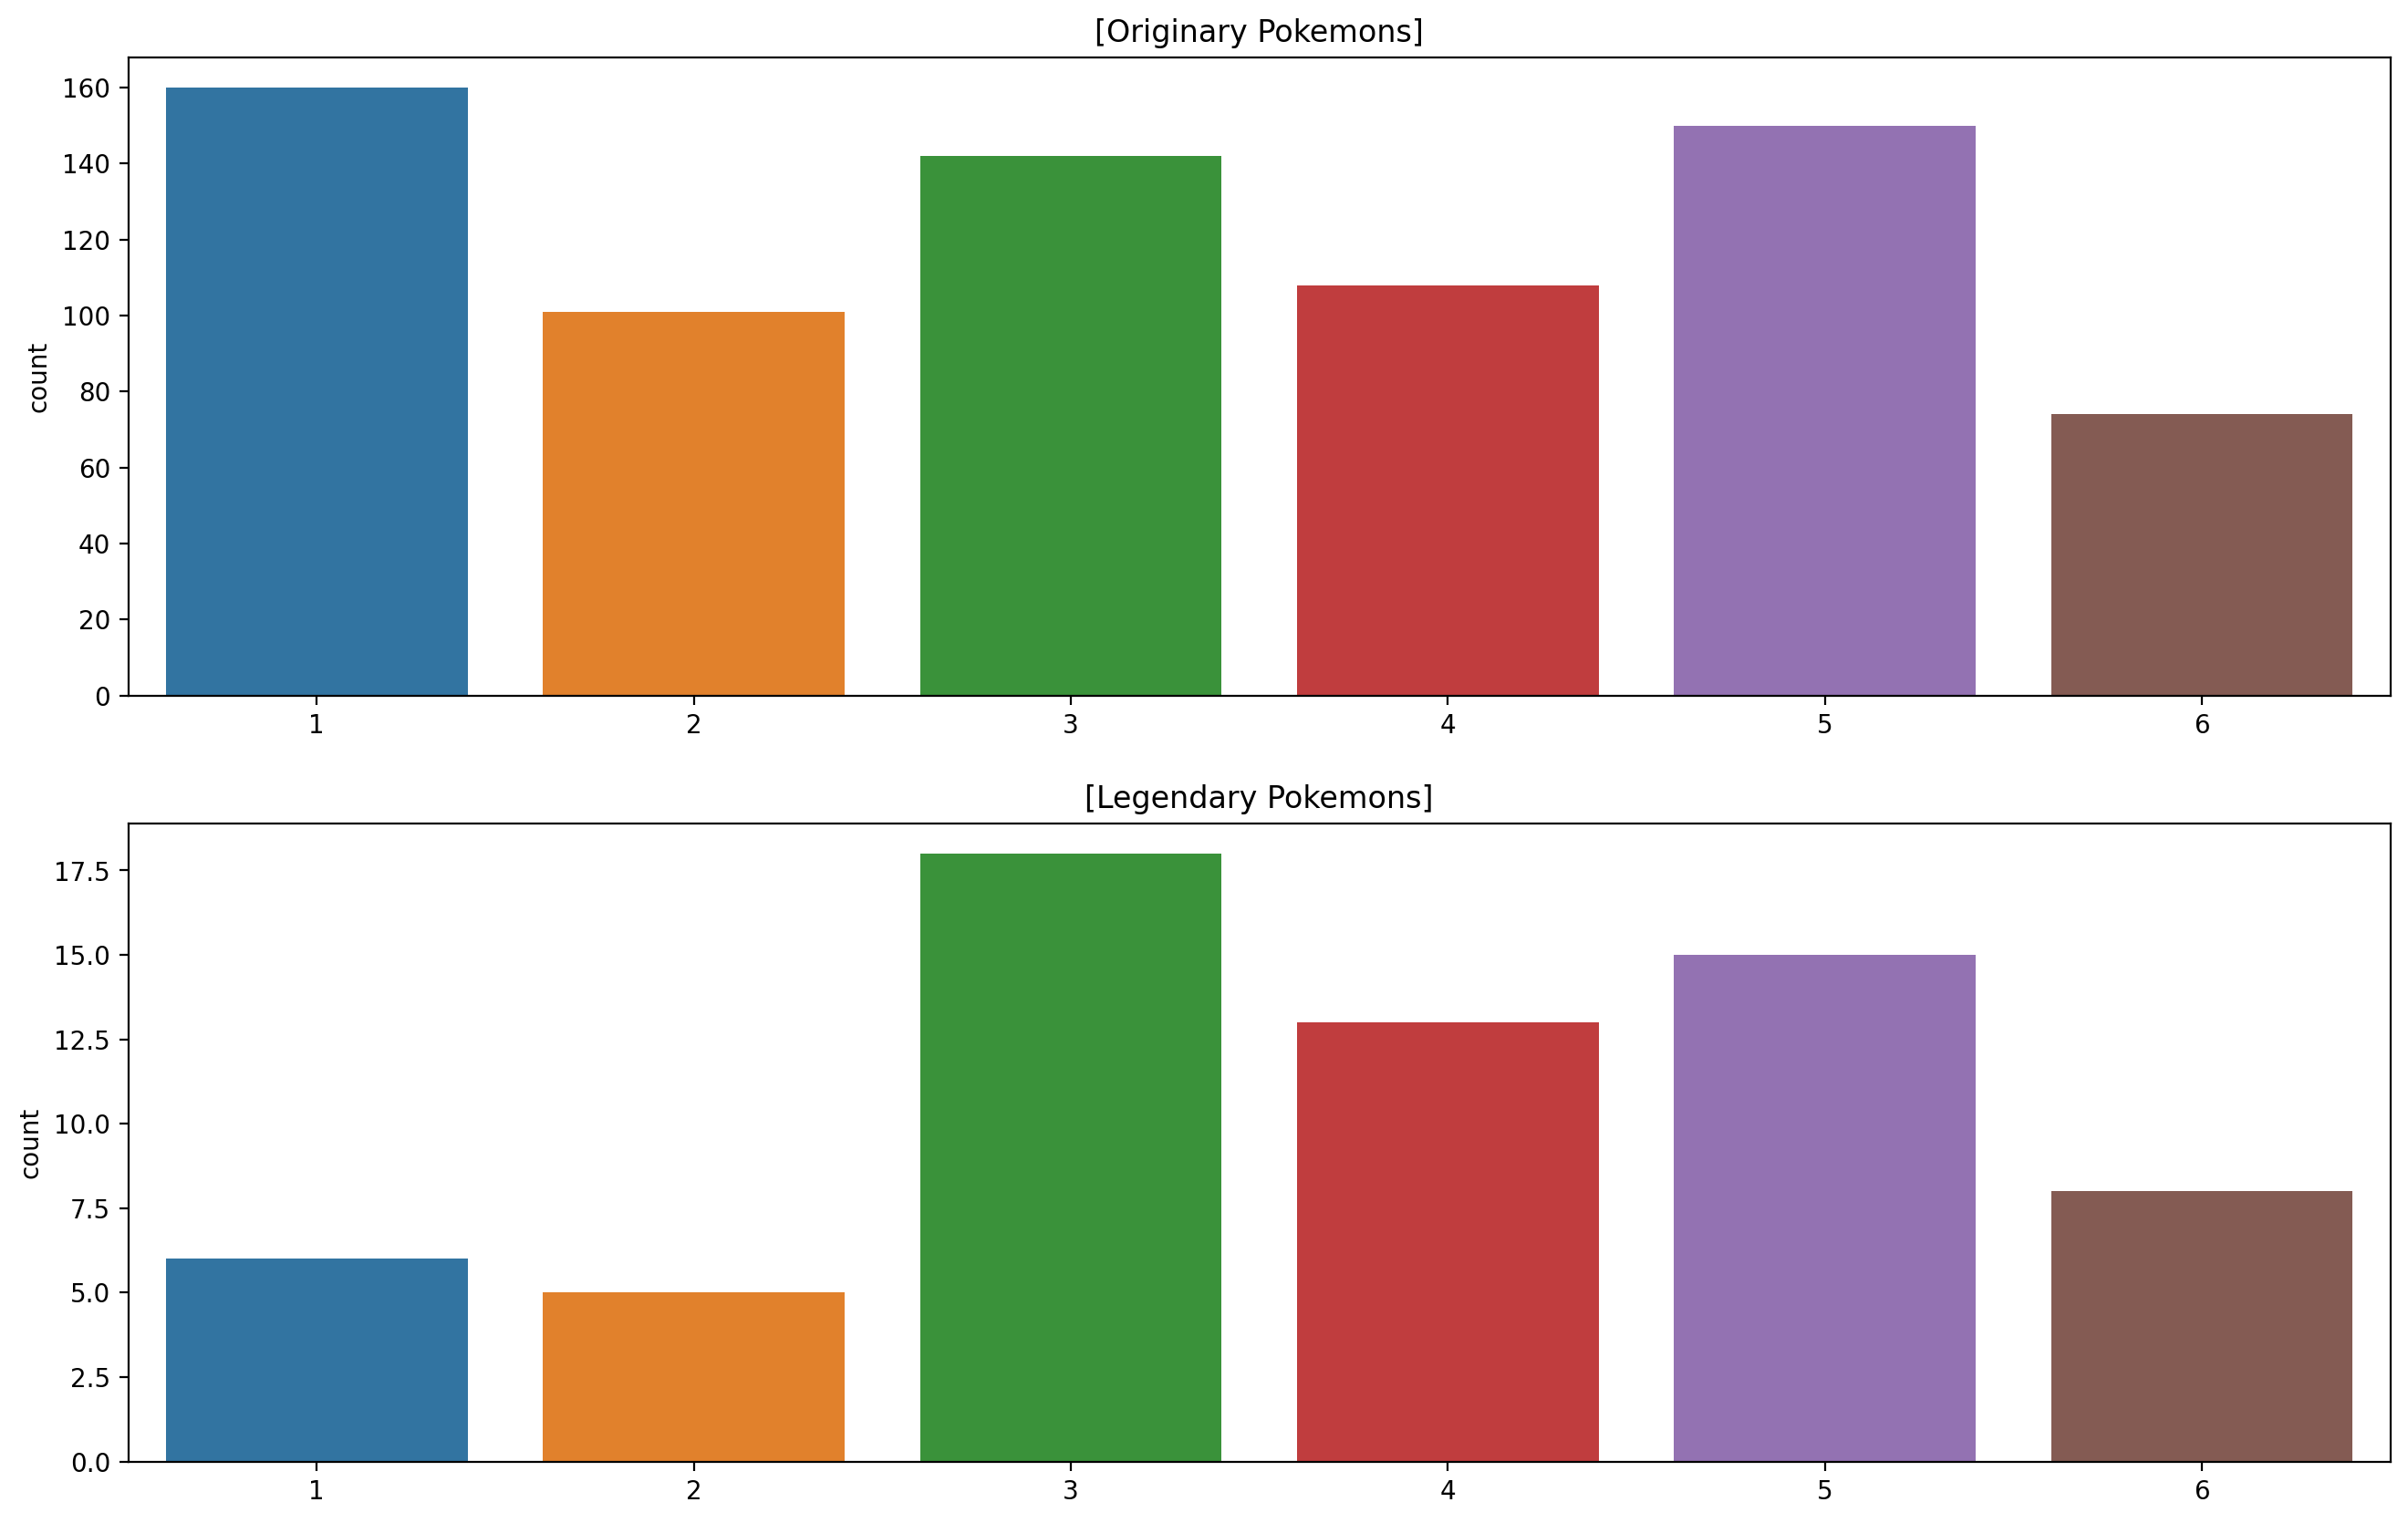

In [27]:
plt.figure(figsize=(16, 10))   # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=originary, x="Generation").set_xlabel('')
plt.title("[Originary Pokemons]")
plt.subplot(212)
sns.countplot(data=legendary, x="Generation").set_xlabel('')
plt.title("[Legendary Pokemons]")
plt.show()

일반 포켓몬은 1세대 때 미친듯이 많았고, 6세대 때가 제일 적은 수를 가지고

레전드 포켓몬은 1세대 때 가장 많았던것에 비해 매우 적었으며, 또한 레전드 포켓몬은 3세대부터 많았다.

## 전설의 포켓몬 Total 값 시각화

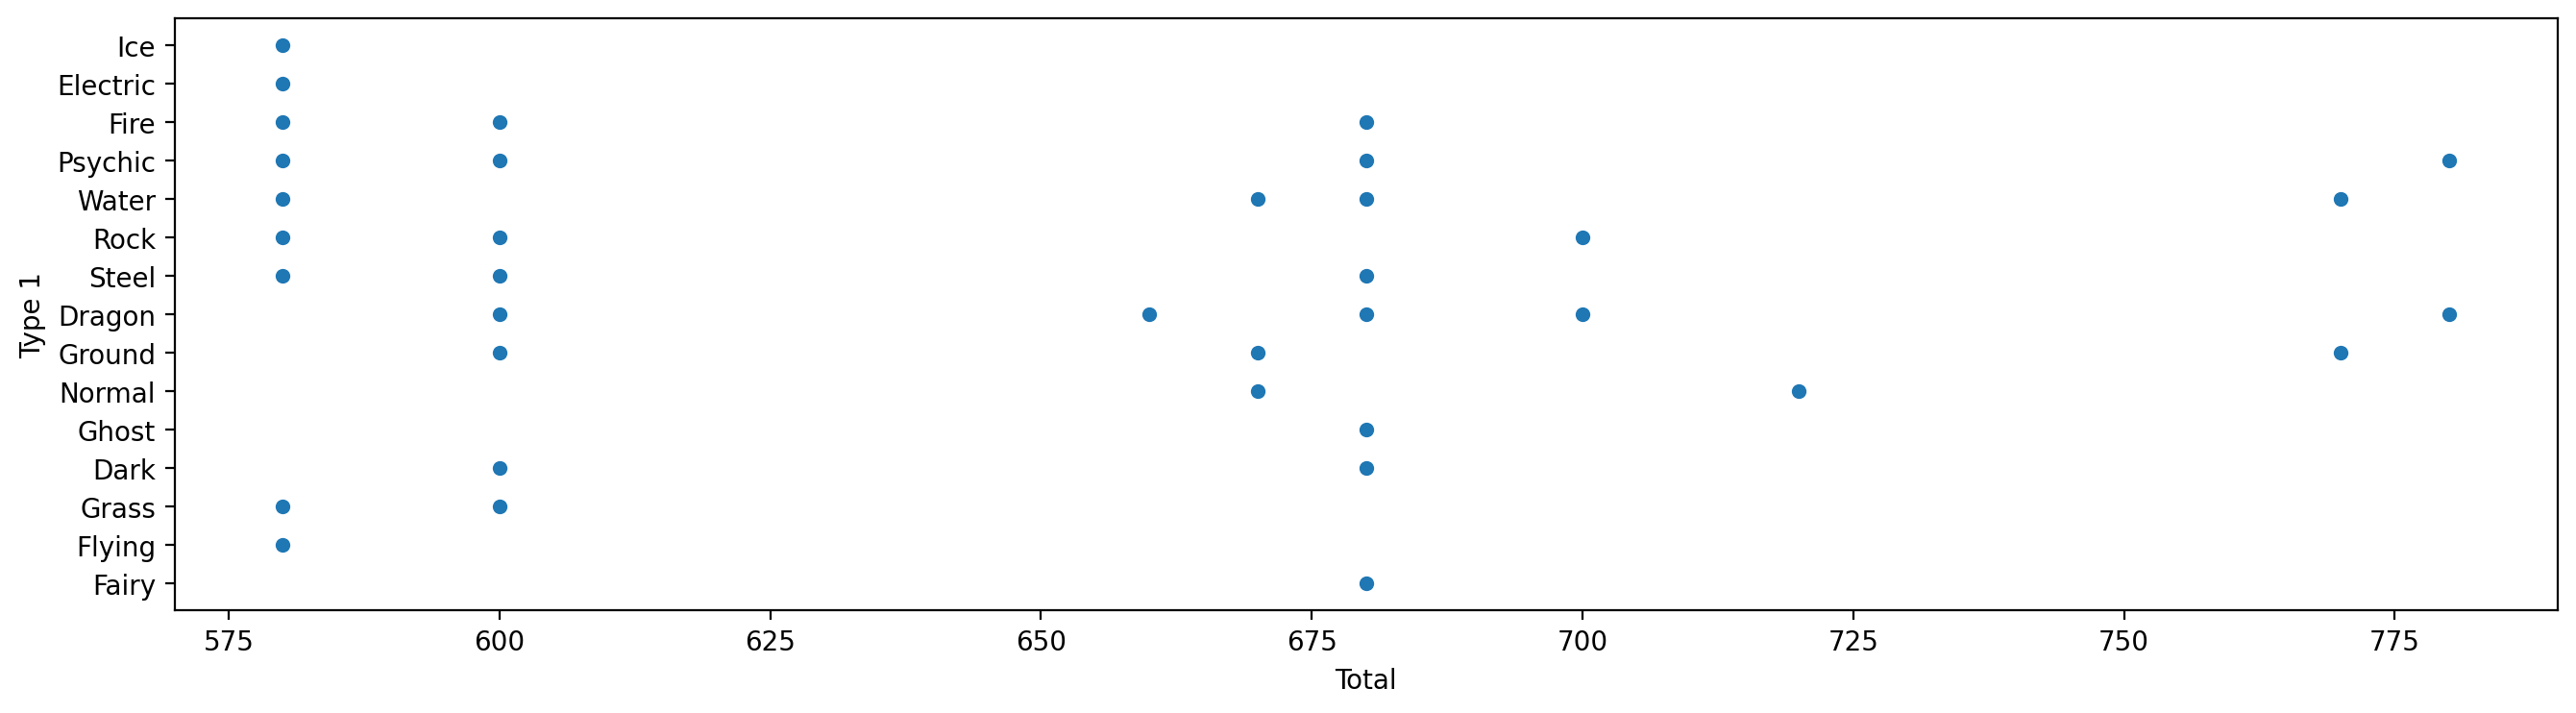

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)

sns.scatterplot(data=legendary, y="Type 1", x="Total")
plt.show()

In [29]:
print(sorted(list(set(legendary["Total"]))))
print(len(list(set(legendary["Total"]))))

[580, 600, 660, 670, 680, 700, 720, 770, 780]
9


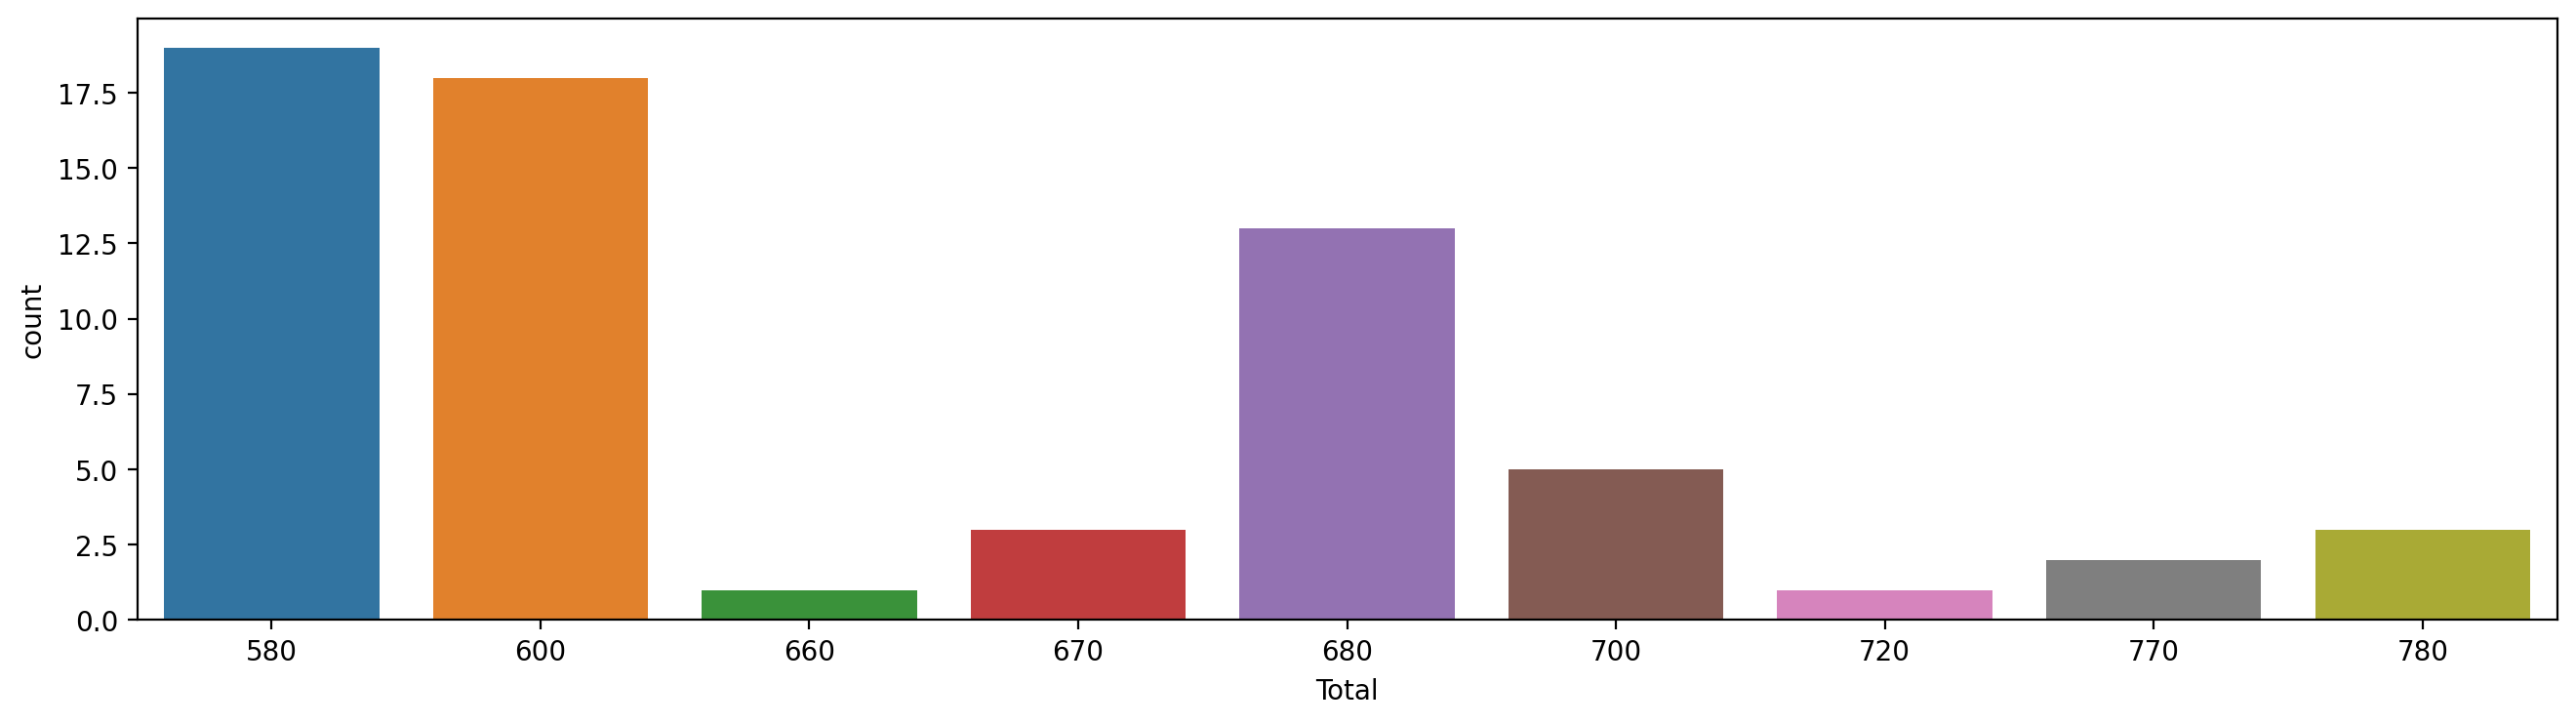

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)

sns.countplot(data=legendary, x="Total")
plt.show()

In [31]:
# 65는 전설의포켓몬 마리수, 9는 분포되어있는 Total 값, 2는 소수점 둘째자리까지 표기
round(65 / 9, 2)

7.22

약 7.22마리 끼리는 같은 Total 스탯 값을 가진다

## 일반 포켓몬 Total 값 시각화

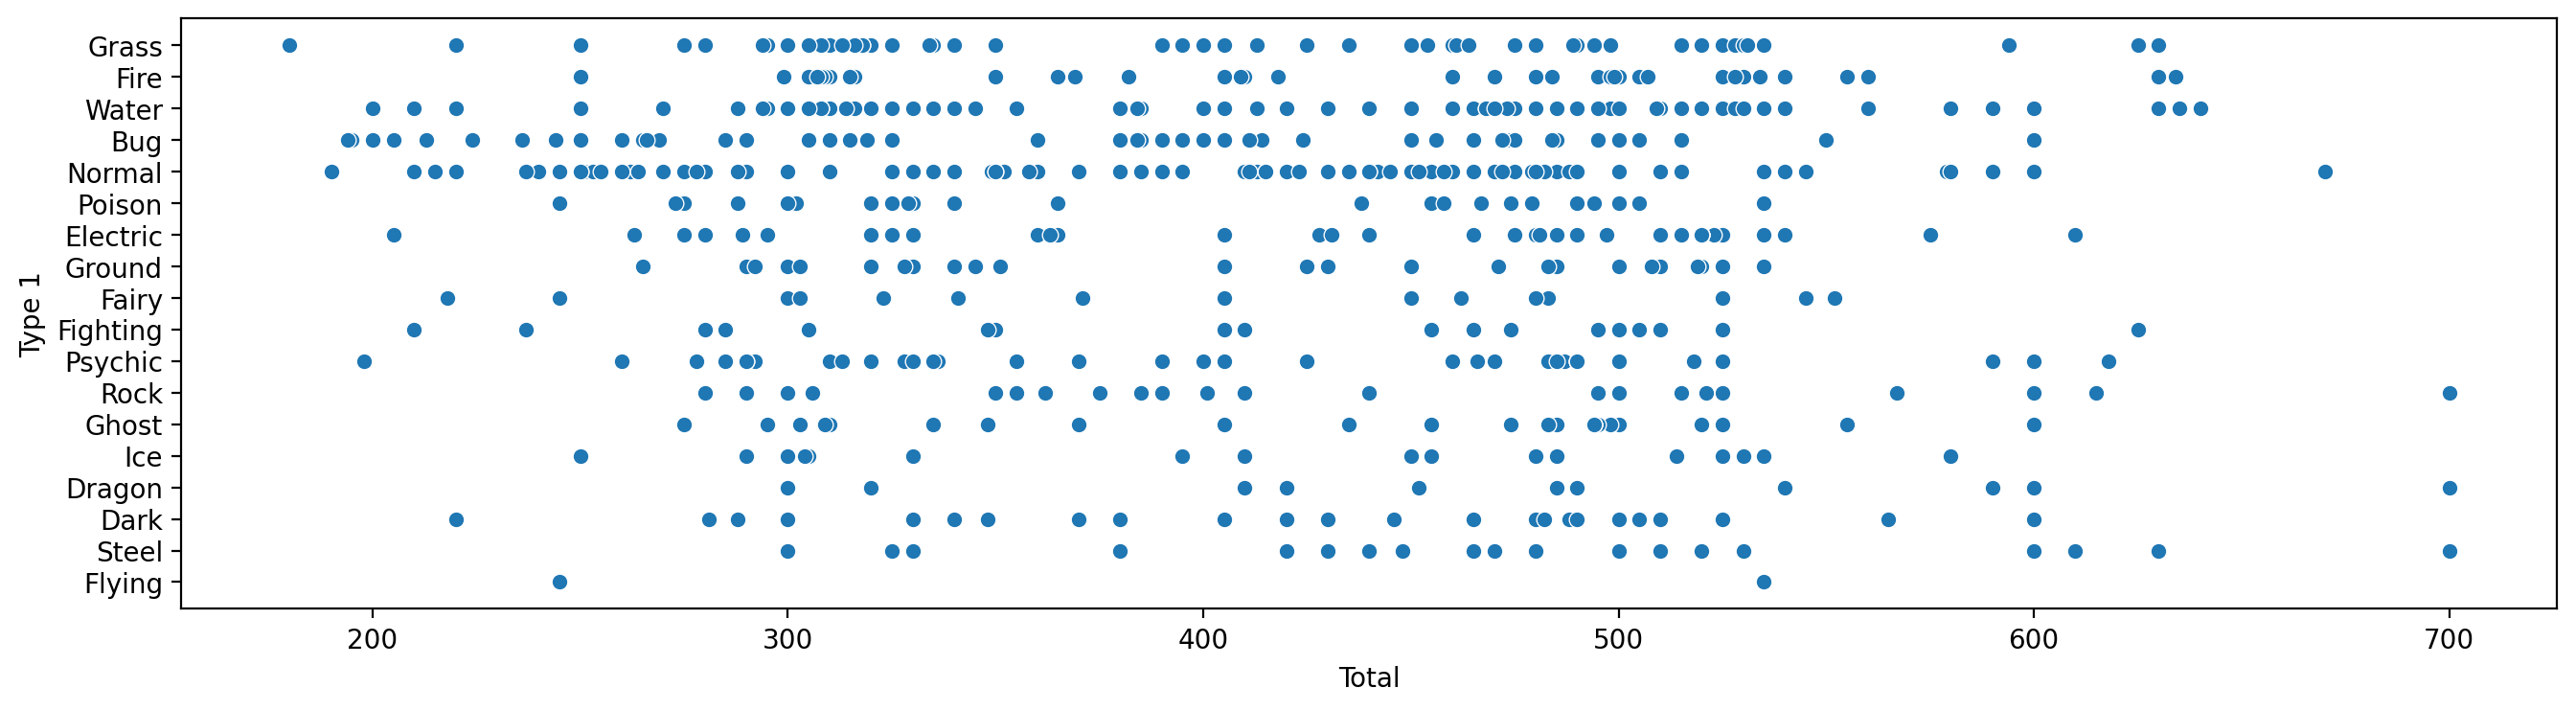

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)

sns.scatterplot(data=originary, y="Type 1", x="Total")
plt.show()

In [33]:
print(sorted(list(set(originary["Total"]))))
print(len(list(set(originary["Total"]))))

[180, 190, 194, 195, 198, 200, 205, 210, 213, 215, 218, 220, 224, 236, 237, 240, 244, 245, 250, 251, 253, 255, 260, 262, 263, 264, 265, 266, 269, 270, 273, 275, 278, 280, 281, 285, 288, 289, 290, 292, 294, 295, 299, 300, 302, 303, 304, 305, 306, 307, 308, 309, 310, 313, 314, 315, 316, 318, 319, 320, 323, 325, 328, 329, 330, 334, 335, 336, 340, 341, 345, 348, 349, 350, 351, 352, 355, 358, 360, 362, 363, 365, 369, 370, 371, 375, 380, 382, 384, 385, 390, 395, 400, 401, 405, 409, 410, 411, 413, 414, 415, 418, 420, 423, 424, 425, 428, 430, 431, 435, 438, 440, 442, 445, 446, 448, 450, 452, 454, 455, 456, 458, 460, 461, 462, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475, 479, 480, 481, 482, 483, 484, 485, 487, 488, 489, 490, 494, 495, 497, 498, 499, 500, 505, 507, 508, 509, 510, 514, 515, 518, 519, 520, 521, 523, 525, 528, 530, 531, 534, 535, 540, 545, 550, 552, 555, 560, 565, 567, 575, 579, 580, 590, 594, 600, 610, 615, 618, 625, 630, 634, 635, 640, 670, 700]
195


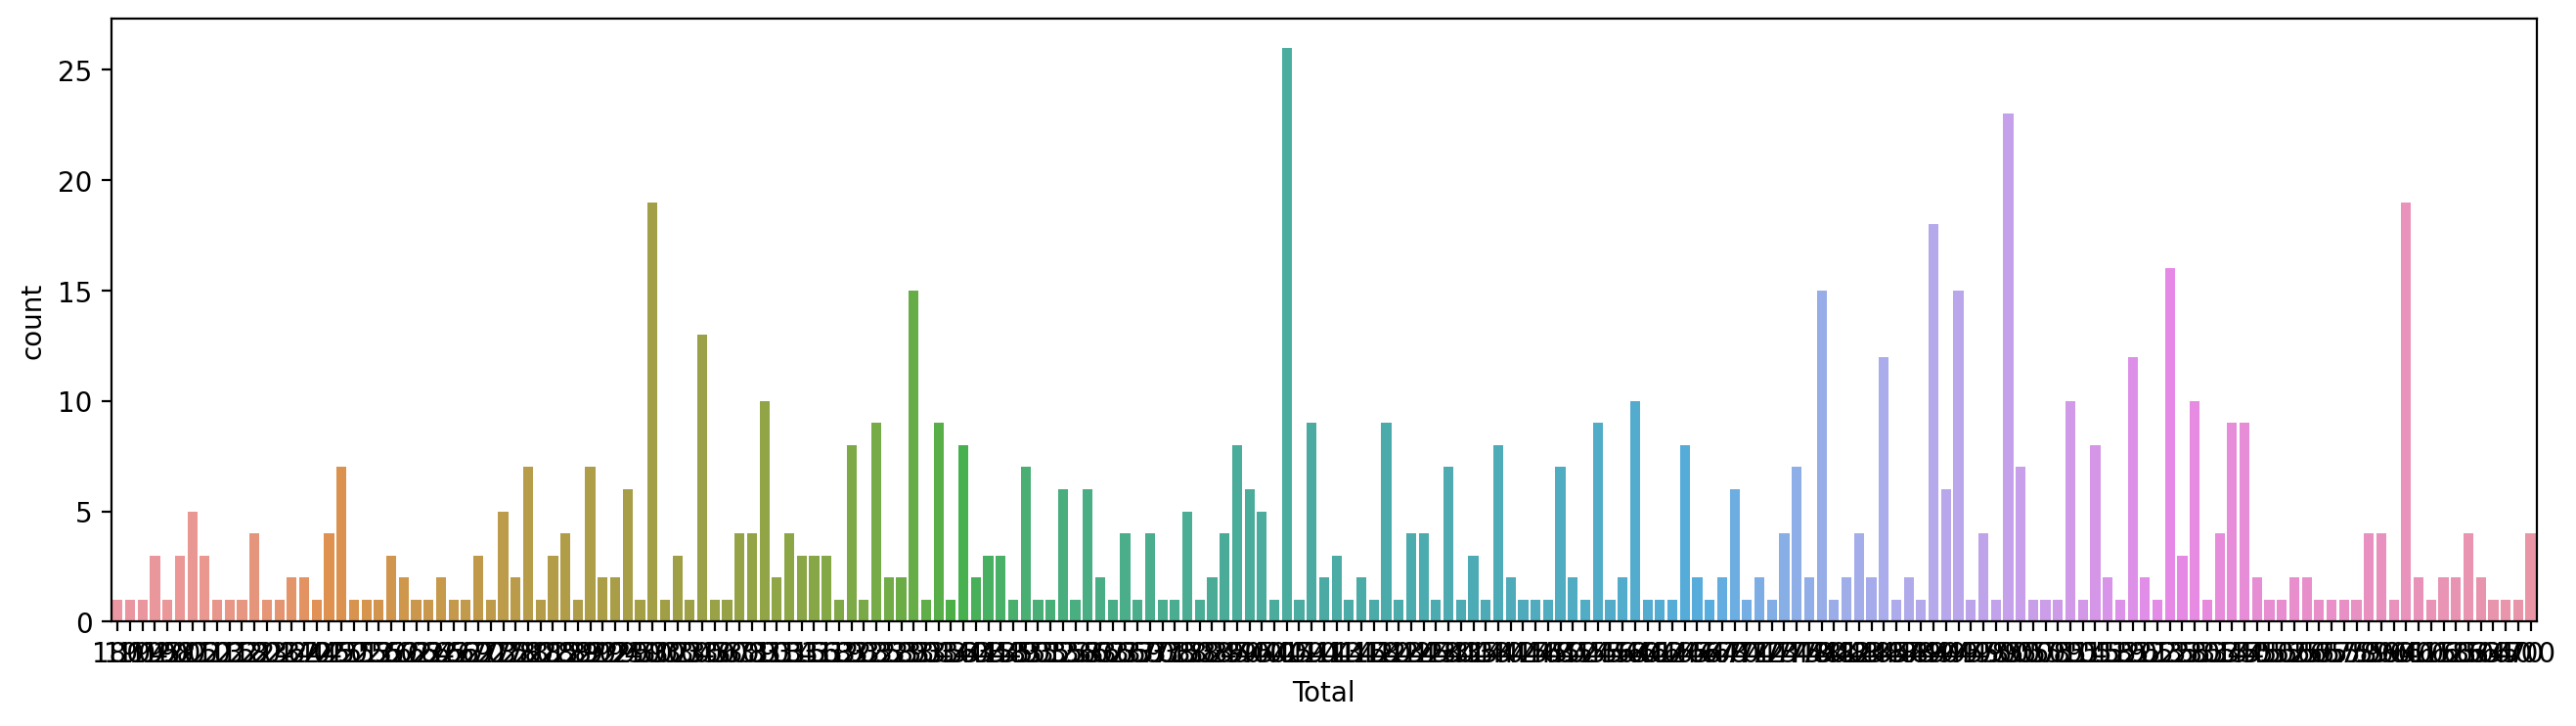

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 4)

sns.countplot(data=originary, x="Total")
plt.show()

In [35]:
round(735 / 195, 2)

3.77

약 3.77마리 끼리는 같은 Total 스탯 값을 가진다

In [36]:
# 일반 몬스터가 가지지 못한 레전드의 Total 값
set(legendary["Total"]) - set(originary["Total"])

{660, 680, 720, 770, 780}

## 특정 이름이 들어간 칼럼 확인하기

In [37]:
n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
names = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)
names

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
1,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True
2,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True
3,380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
4,380,LatiasMega Latias,Dragon,Psychic,700,80,100,120,140,150,110,3,True
5,381,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,True
6,381,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,True
7,382,Kyogre,Water,NaN,670,100,100,90,150,140,90,3,True
8,382,KyogrePrimal Kyogre,Water,NaN,770,100,150,90,180,160,90,3,True
9,383,Groudon,Ground,NaN,670,100,150,140,100,90,90,3,True


In [38]:
formes = names[13:23]
formes

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
13,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
14,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
15,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
16,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True
17,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True
18,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
19,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True
20,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True
21,645,LandorusIncarnate Forme,Ground,Flying,600,89,125,90,115,80,101,5,True
22,645,LandorusTherian Forme,Ground,Flying,600,89,145,90,105,80,91,5,True


## 레전드 포켓몬과 일반 포켓몬 글자수 확인 및 시각화

In [39]:
# Name 칼럼의 글자수를 count 하기
legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))
legendary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,8
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,6
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,7
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,6
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,19


In [40]:
# Name 칼럼의 글자수를 count 하기
originary["name_count"] = originary["Name"].apply(lambda i: len(i))
originary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


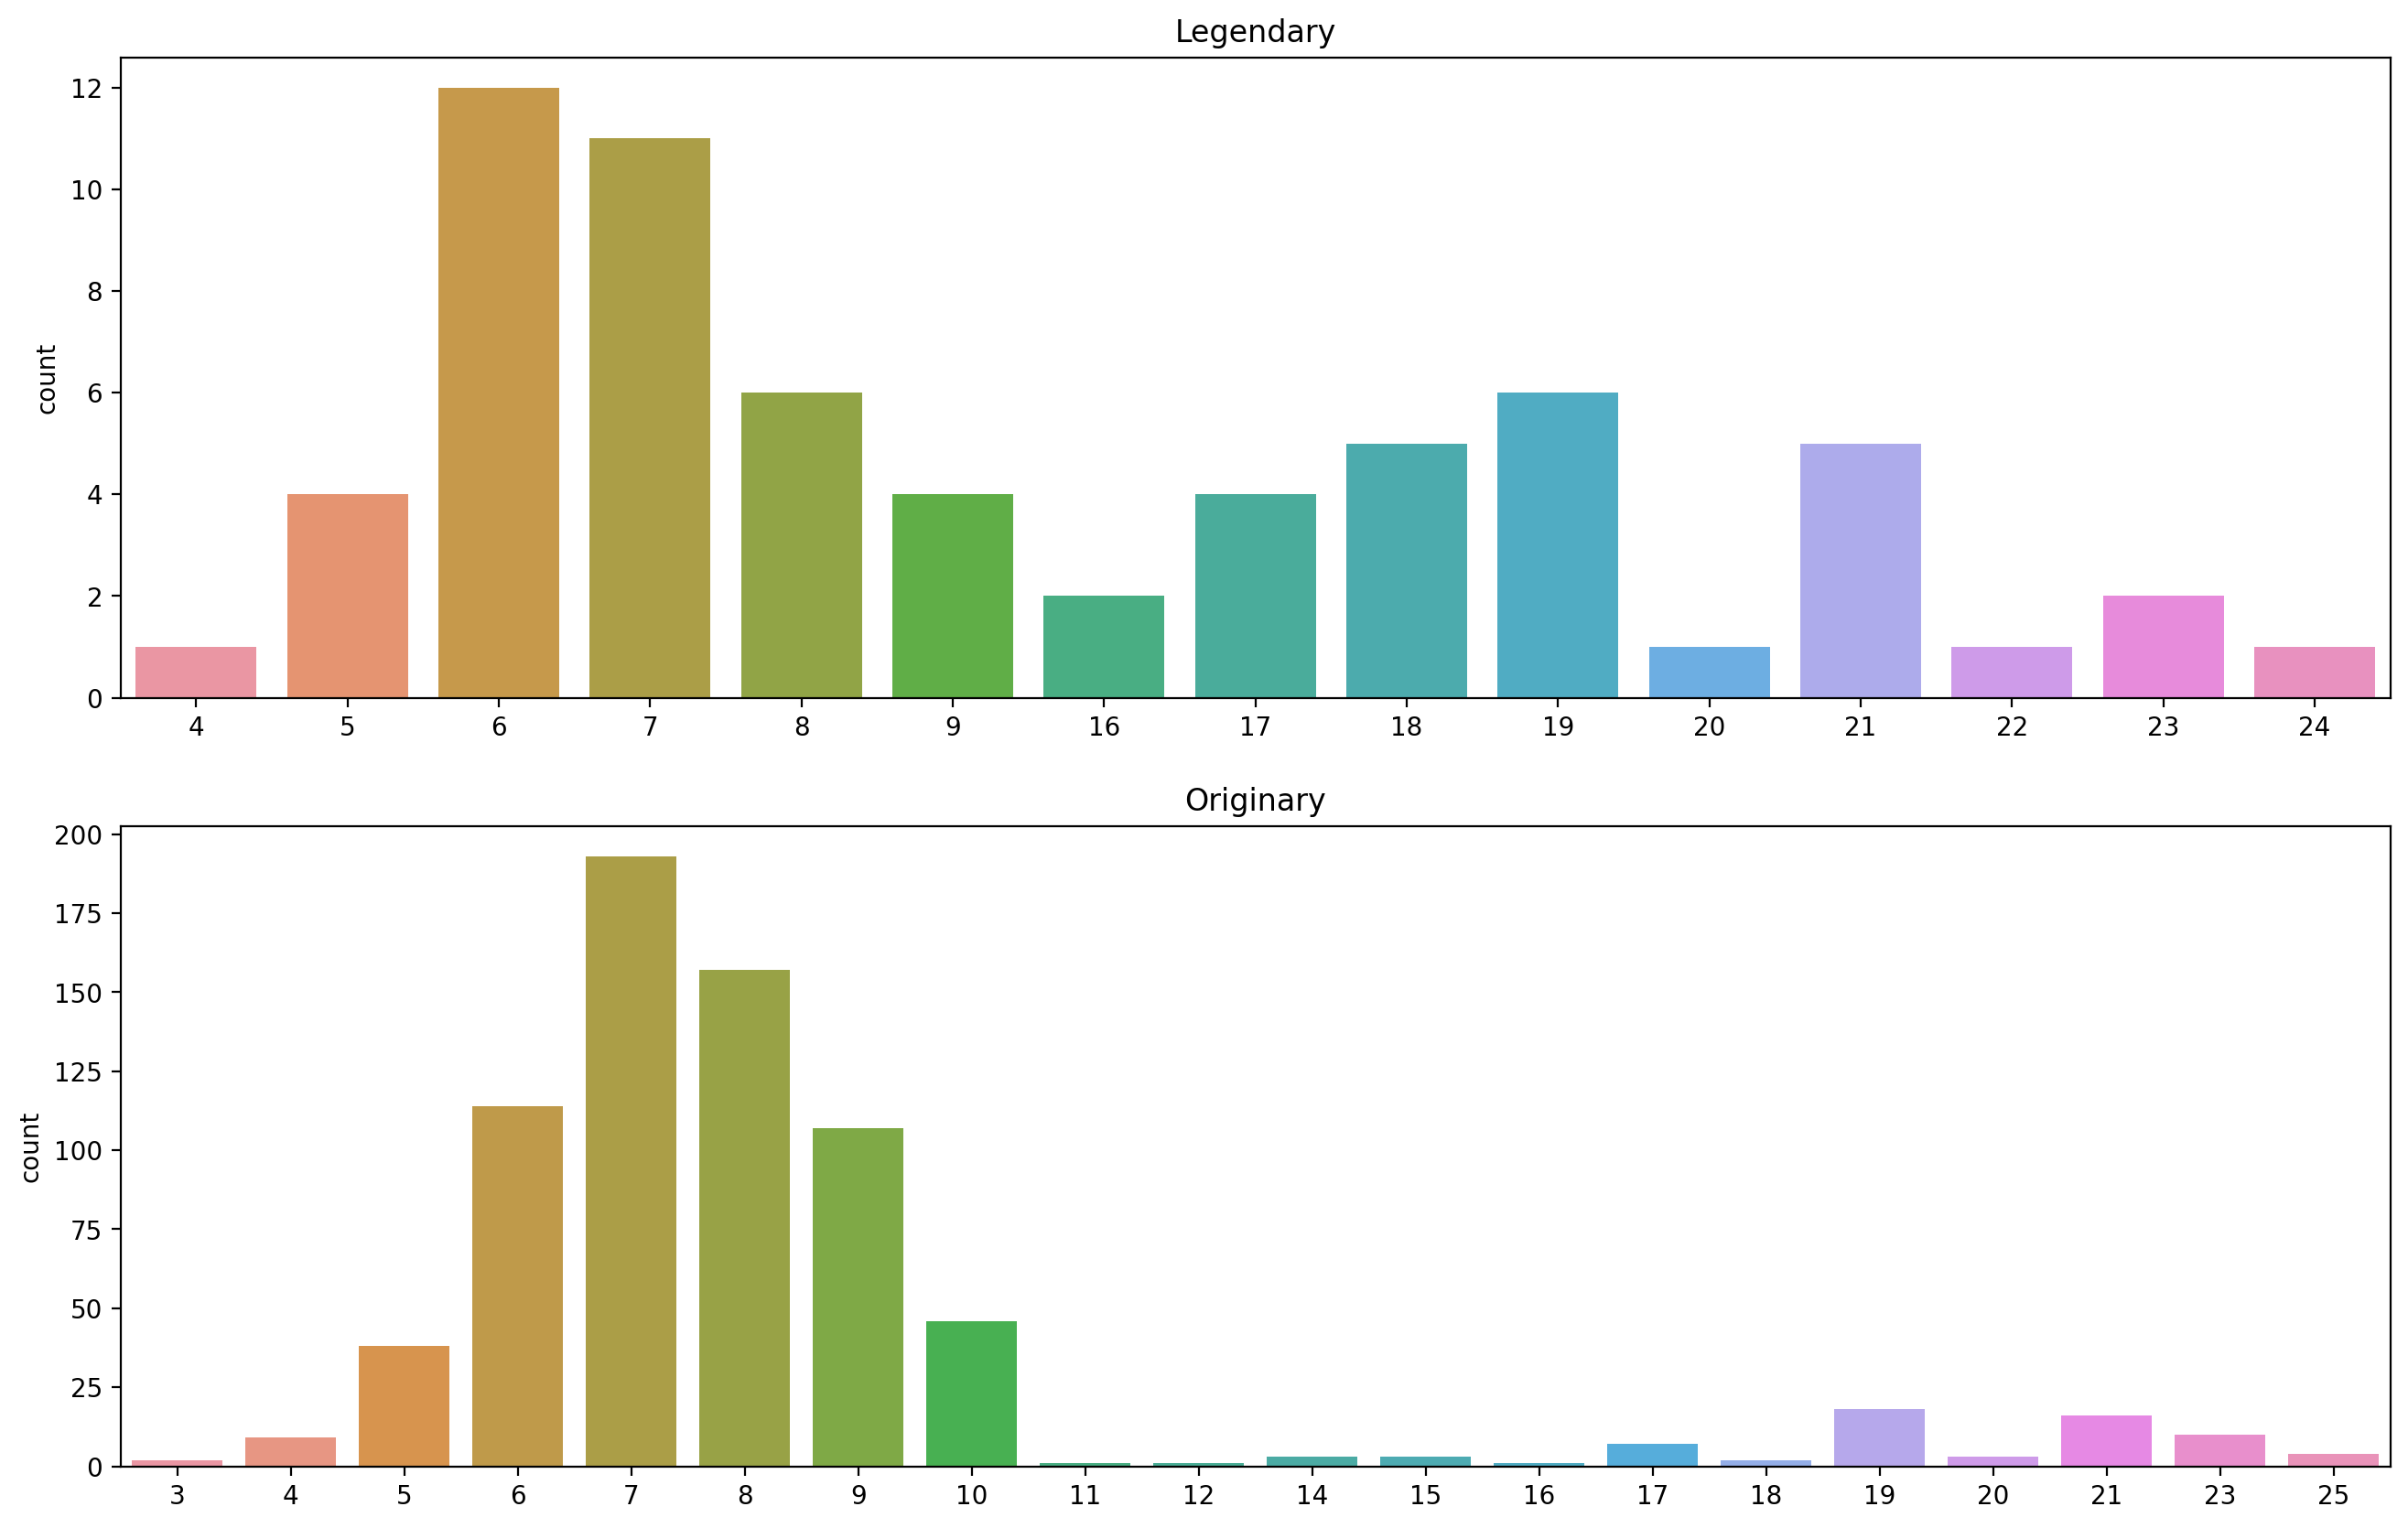

In [41]:
plt.figure(figsize=(16, 10))

plt.subplot(211)
sns.countplot(data=legendary, x="name_count").set_xlabel('')
plt.title("Legendary")
plt.subplot(212)
sns.countplot(data=originary, x="name_count").set_xlabel('')
plt.title("Originary")
plt.show()

일반 포켓몬의 이름은 10글자를 초과하는 포켓몬이 별로 없다.

레전드 포켓몬은 10글자를 초과하는 포켓몬이 높은 비율로 있다.

In [42]:
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")

41.54 %


In [43]:
print(round(len(originary[originary["name_count"] > 9]) / len(originary) * 100, 2), "%")

15.65 %


만약 "Latios"가 전설의 포켓몬이라면, "%%% Latios" 또한 전설의 포켓몬이다!

적어도 전설의 포켓몬에서 높은 빈도를 보이는 이름들의 모임이 존재한다!

전설의 포켓몬은 긴 이름을 가졌을 확률이 높다!

## Long_name 칼럼을 만들어서 10글자 이상 True 이하 False

In [44]:
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


In [45]:
pokemon["long_name"] = pokemon["name_count"] >= 10
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


## 이름에 자주쓰이는 토큰 추출

In [46]:
# 띄어쓰기 제거하기
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7,False,Diancie
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19,True,DiancieMegaDiancie
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19,True,HoopaHoopaConfined
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18,True,HoopaHoopaUnbound
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9,False,Volcanion


In [47]:
# isalpha 함수는 문자열 전체가 알파벳으로 되어있는지 확인해주는 함수
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False,Bulbasaur,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False,Ivysaur,True
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False,Venusaur,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True,VenusaurMegaVenusaur,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True,Charmander,True


In [48]:
# 알파벳이 아닌것이 들어가 있는지 확인
print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

(9, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran♀,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran♂,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetch'd,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon2,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho-oh,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon-Z,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [49]:
# 알파벳 말고 다른것들이 들은 데이터를 수동적으로 변경 한후 데이터프레임 확인
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [50]:
# 다시 띄어쓰기 제거한후, 알파벳으로만되어있는지 확인
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
# False 값이 있는지 확인
pokemon[pokemon["name_isalpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha


In [51]:
def tokenize(name):
    tokens = []
    name_split = name.split(" ")
    for part_name in name_split:
        a = re.findall('[A-Z][a-z]*', part_name)
        tokens.extend(a)

    return np.array(tokens)

- [A-Z] : A부터 Z까지의 대문자 중 한 가지로 시작하고,
- [a-z] : 그 뒤에 a부터 z까지의 소문자 중 한 가지가 붙는데,
- \* : 그 소문자의 개수는 하나 이상인 패턴 (*는 정규표현식 중에서 "반복"을 나타내는 기호)

In [52]:
all_tokens = list(legendary["Name"].apply(tokenize).values)

token_set = []
for token in all_tokens:
    token_set.extend(token)

print(len(set(token_set)))
print(token_set)

65
['Articuno', 'Zapdos', 'Moltres', 'Mewtwo', 'Mewtwo', 'Mega', 'Mewtwo', 'X', 'Mewtwo', 'Mega', 'Mewtwo', 'Y', 'Raikou', 'Entei', 'Suicune', 'Lugia', 'Ho', 'Regirock', 'Regice', 'Registeel', 'Latias', 'Latias', 'Mega', 'Latias', 'Latios', 'Latios', 'Mega', 'Latios', 'Kyogre', 'Kyogre', 'Primal', 'Kyogre', 'Groudon', 'Groudon', 'Primal', 'Groudon', 'Rayquaza', 'Rayquaza', 'Mega', 'Rayquaza', 'Jirachi', 'Deoxys', 'Normal', 'Forme', 'Deoxys', 'Attack', 'Forme', 'Deoxys', 'Defense', 'Forme', 'Deoxys', 'Speed', 'Forme', 'Uxie', 'Mesprit', 'Azelf', 'Dialga', 'Palkia', 'Heatran', 'Regigigas', 'Giratina', 'Altered', 'Forme', 'Giratina', 'Origin', 'Forme', 'Darkrai', 'Shaymin', 'Land', 'Forme', 'Shaymin', 'Sky', 'Forme', 'Arceus', 'Victini', 'Cobalion', 'Terrakion', 'Virizion', 'Tornadus', 'Incarnate', 'Forme', 'Tornadus', 'Therian', 'Forme', 'Thundurus', 'Incarnate', 'Forme', 'Thundurus', 'Therian', 'Forme', 'Reshiram', 'Zekrom', 'Landorus', 'Incarnate', 'Forme', 'Landorus', 'Therian', 'Form

### Counter 함수 사용하기

In [53]:
from collections import Counter

In [54]:
most_common = Counter(token_set).most_common(10)
most_common

[('Forme', 15),
 ('Mega', 6),
 ('Mewtwo', 5),
 ('Kyurem', 5),
 ('Deoxys', 4),
 ('Hoopa', 4),
 ('Latias', 3),
 ('Latios', 3),
 ('Kyogre', 3),
 ('Groudon', 3)]

In [55]:
for token, _ in most_common:
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Forme,Mega,Mewtwo,Kyurem,Deoxys,Hoopa,Latias,Latios,Kyogre,Groudon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,...,False,False,False,False,False,False,False,False,False,False
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,...,False,True,False,False,False,False,False,False,False,False
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,...,False,False,False,False,False,True,False,False,False,False
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,...,False,False,False,False,False,True,False,False,False,False


## Type1 & Type2 범주형 데이터 전처리하기

In [56]:
# 원 핫 인코딩 for문으로 돌리기
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t) # | 는 or로 type과 일치할경우 True로 만들어서 원핫인코딩 진행

pokemon[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Fighting,Ice,Fire,Ground,Poison,Rock,Flying,Grass,Normal,Steel,Bug,Psychic,Dragon,Ghost,Dark,Water,Fairy,Electric
0,Grass,Poison,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
1,Grass,Poison,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2,Grass,Poison,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
3,Grass,Poison,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
4,Fire,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [57]:
pokemon

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Normal,Steel,Bug,Psychic,Dragon,Ghost,Dark,Water,Fairy,Electric
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,False,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,...,False,False,False,False,False,False,False,False,True,False
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,...,False,False,False,False,False,False,False,False,True,False
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,...,False,False,False,True,False,True,False,False,False,False
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,...,False,False,False,True,False,False,True,False,False,False


## 가장 기본 데이터로 만드는 베이스라인

In [58]:
print(original_data.shape)
original_data.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [59]:
original_data.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [60]:
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
target = 'Legendary'

In [61]:
X = original_data[features]
print(X.shape)
X.head()

(800, 8)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1


In [62]:
y = original_data[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

## 베이스라인 데이터 모델링

### 데이터 분리

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 8) (640,)
(160, 8) (160,)


### 모델링

In [64]:
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[144,   3],
       [  5,   8]])

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



## 전처리한 포켓몬 데이터 모델링

In [66]:
print(len(pokemon.columns))
print(pokemon.columns)

45
Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'name_count',
       'long_name', 'Name_nospace', 'name_isalpha', 'Forme', 'Mega', 'Mewtwo',
       'Kyurem', 'Deoxys', 'Hoopa', 'Latias', 'Latios', 'Kyogre', 'Groudon',
       'Fighting', 'Ice', 'Fire', 'Ground', 'Poison', 'Rock', 'Flying',
       'Grass', 'Normal', 'Steel', 'Bug', 'Psychic', 'Dragon', 'Ghost', 'Dark',
       'Water', 'Fairy', 'Electric'],
      dtype='object')


In [67]:
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation',
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']

len(features)

38

In [68]:
target = "Legendary"
target

'Legendary'

In [69]:
X = pokemon[features]
print(X.shape)
X.head()

(800, 38)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count,long_name,...,Dark,Fairy,Steel,Ghost,Psychic,Ice,Bug,Grass,Dragon,Fighting
0,318,45,49,49,65,65,45,1,9,False,...,False,False,False,False,False,False,False,True,False,False
1,405,60,62,63,80,80,60,1,7,False,...,False,False,False,False,False,False,False,True,False,False
2,525,80,82,83,100,100,80,1,8,False,...,False,False,False,False,False,False,False,True,False,False
3,625,80,100,123,122,120,80,1,21,True,...,False,False,False,False,False,False,False,True,False,False
4,309,39,52,43,60,50,65,1,10,True,...,False,False,False,False,False,False,False,False,False,False


In [70]:
y = pokemon[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

### 데이터 분리

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 38) (640,)
(160, 38) (160,)


### 모델링

In [72]:
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
pred = model.predict(X_test)
confusion = confusion_matrix(y_test, pred)
print(f"Confusion Matrix:\n{confusion}")
classifcation = classification_report(y_test, pred)
print(f"Classification Report :\n{classifcation}")

Confusion Matrix:
[[141   6]
 [  1  12]]
Classification Report :
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



# 회고
저번에 pandas를 할 때 pokemon EDA를 하다가 말았었는데, 그때는 세대별 전설 포켓몬, 일반 포켓몬 분류 같은 기초적인것만 했었는데 엄청 자세하고 딥하게 전처리 하고 탐색 데이터 분석 하는것은 처음 해보았던 것 같습니다.

프로젝트 할때도 항상 필요한 내용만 하고 끝내버렸었는데 이렇게 진행 해본 것은 많이 경험이 되었습니다.

countplot, pivot, scatterplot 등 다양한 것에 대해 다시한번 이해 한 것 같습니다.

- K
    - 프로젝트 제출전 다시 정리 하는 것
- P
    - 제출 방식을 제대로 듣지 못하고 노드에서만 끝냈던 점
    - 뒤죽박죽 했었던 코드
    - 부족했던 설명
- T
    - 코랩에 다시 정리 한것
    - 코드별로 텍스트로 구분 다시 지은 것
    - 노드에 있는 설명과 구글링을 해서 주석으로 필요한 설명 추가한 것